# 2024 CITS4012 Project

_Make sure you change the file name with your group id._


# Readme

_If there is something to be noted for the marker, please mention here._

_If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file_


# 1.Dataset Processing

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


### 1.1 Import Dependencies


In [72]:
import json, re, random, os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from typing import Dict, List, Tuple
# from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### 1.2 Set Seed for Reproducibility


In [73]:
CUDA = torch.cuda.is_available()
MY_DEVICE = torch.device('cuda' if CUDA else 'cpu'); print(f"Using device: {MY_DEVICE}")

SEED = 42 
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if CUDA: torch.cuda.manual_seed_all(SEED)

Using device: cpu


In [74]:
TRAIN_PATH = 'data/train.json'
VAL_PATH = 'data/validation.json'
TEST_PATH = 'data/test.json'

In [75]:
def load_nli_dataset(file_path):
    """
    Load NLI dataset from JSON file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    examples = []
    for idx in range(len(data['premise'])):
        example = {
            'premise': data['premise'][str(idx)],
            'hypothesis': data['hypothesis'][str(idx)],
            'label': data['label'][str(idx)]
        }
        examples.append(example)
    return examples

def load_all_datasets():
    """Load all datasets (train, validation, test)"""
    train_data = load_nli_dataset(TRAIN_PATH)
    val_data = load_nli_dataset(VAL_PATH)
    test_data = load_nli_dataset(TEST_PATH)
    print(f">>> {len(train_data) + len(val_data) + len(test_data)} examples loaded:\n"
          f"    Training:   {len(train_data):,} examples\n"
          f"    Validation: {len(val_data):,} examples\n"
          f"    Test:       {len(test_data):,} examples")
    return train_data, val_data, test_data

train_data, val_data, test_data = load_all_datasets()

>>> 26518 examples loaded:
    Training:   23,088 examples
    Validation: 1,304 examples
    Test:       2,126 examples


### 1.3 Exploratory Data Analysis



Sample Examples (from Training set):

  Example 1:
    Premise: Pluto rotates once on its axis every 6.39 Earth days;...
    Hypothesis: Earth rotates on its axis once times in one day....
    Label: neutral

  Example 2:
    Premise: ---Glenn ========================================================= Once per day, the earth rotates a...
    Hypothesis: Earth rotates on its axis once times in one day....
    Label: entails


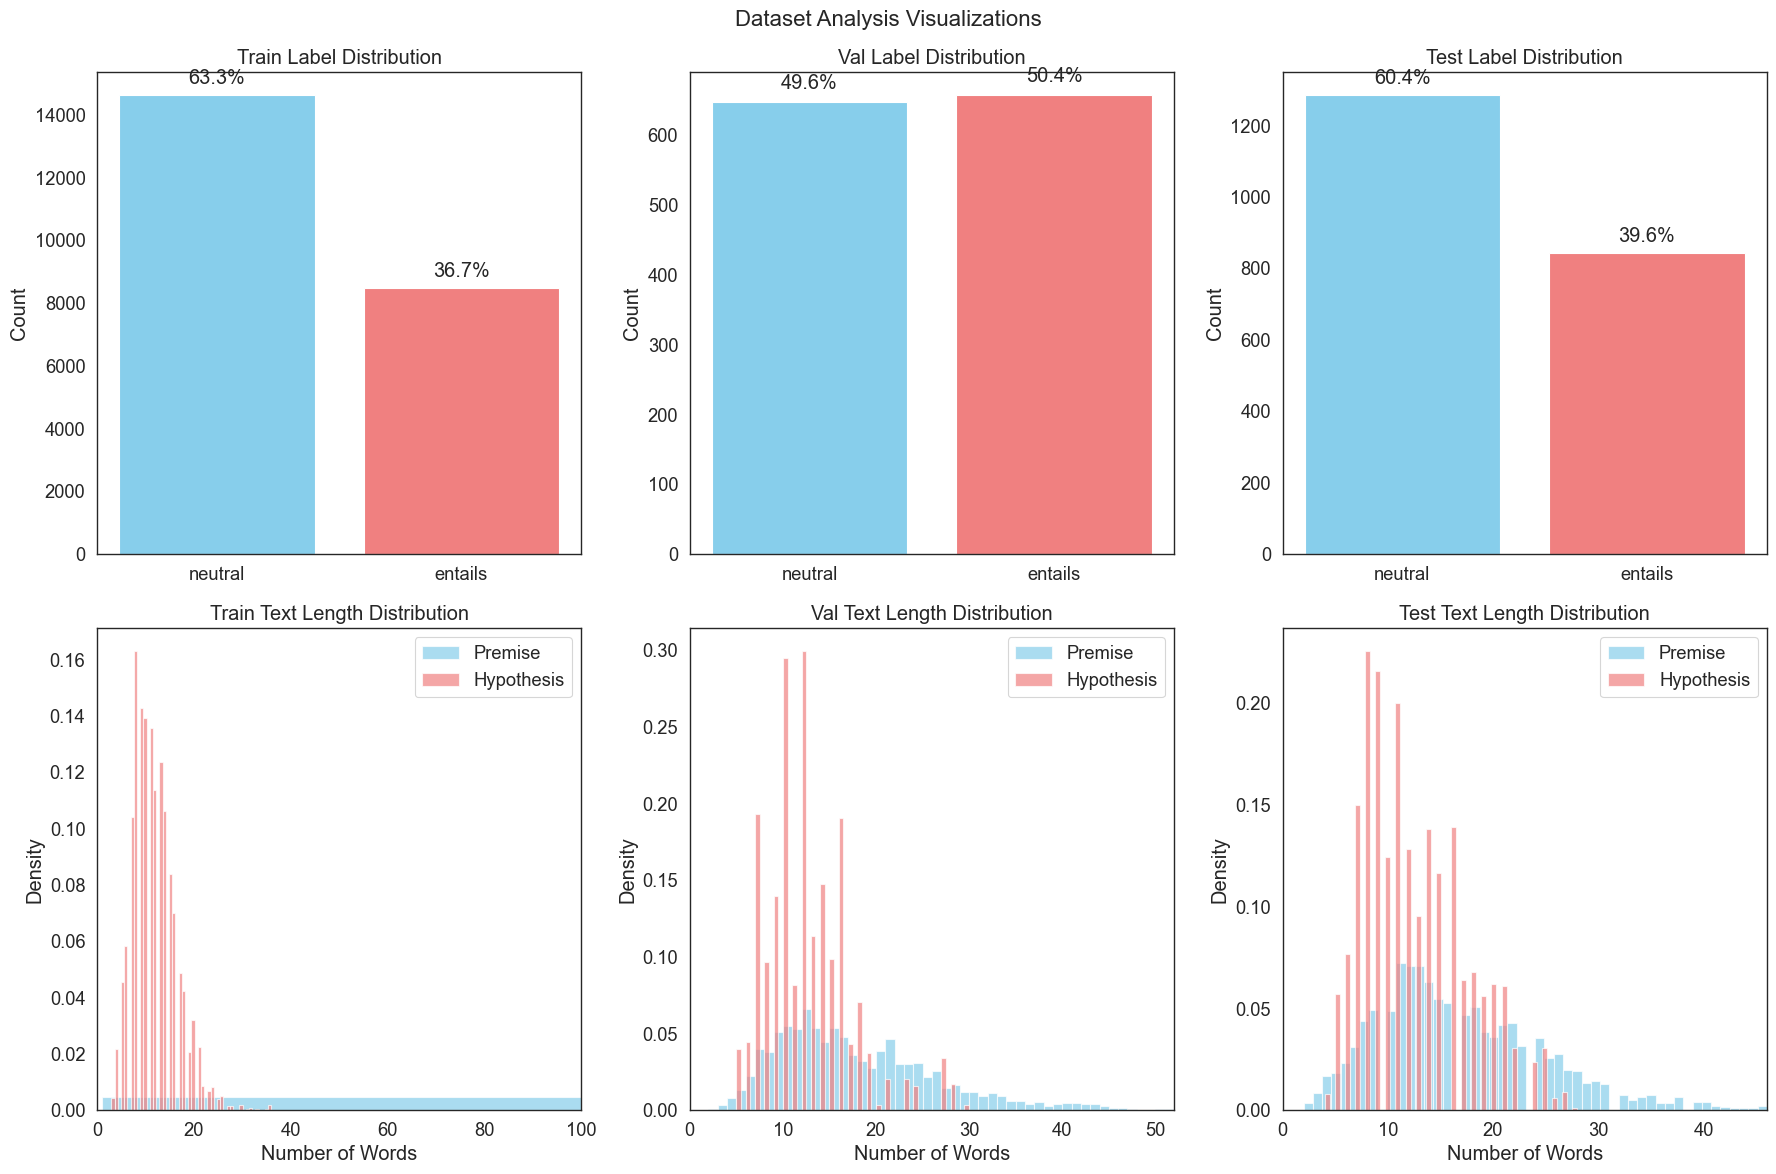

In [76]:
def analyze_dataset(data, dataset_name="", show_samples=False):
    """
    """
    labels = [example['label'] for example in data]
    label_counts = Counter(labels)
    premise_lengths = [len(example['premise'].split()) for example in data]
    hypothesis_lengths = [len(example['hypothesis'].split()) for example in data]
    
    if show_samples:
        print(f"\nSample Examples (from {dataset_name} set):")
        for i, example in enumerate(data[:2]):
            print(f"\n  Example {i+1}:")
            print(f"    Premise: {example['premise'][:100]}...")
            print(f"    Hypothesis: {example['hypothesis'][:100]}...")
            print(f"    Label: {example['label']}")
    
    return {
        'label_counts': label_counts,
        'premise_lengths': premise_lengths,
        'hypothesis_lengths': hypothesis_lengths
    }

def create_visualizations(train_stats, val_stats, test_stats):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Dataset Analysis Visualizations', fontsize=16)
    datasets = ['Train', 'Val', 'Test']
    stats_list = [train_stats, val_stats, test_stats]
    
    for i, (dataset, stats) in enumerate(zip(datasets, stats_list)):
        labels = list(stats['label_counts'].keys())
        counts = list(stats['label_counts'].values())
        axes[0, i].bar(labels, counts, color=['skyblue', 'lightcoral'])
        axes[0, i].set_title(f'{dataset} Label Distribution')
        axes[0, i].set_ylabel('Count')
        total = sum(counts)
        for j, count in enumerate(counts):
            percentage = (count / total) * 100
            axes[0, i].text(j, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom')
    
    for i, (dataset, stats) in enumerate(zip(datasets, stats_list)):
        axes[1, i].hist(stats['premise_lengths'], bins=50, alpha=0.7, 
                       label='Premise', color='skyblue', density=True)
        axes[1, i].hist(stats['hypothesis_lengths'], bins=50, alpha=0.7, 
                       label='Hypothesis', color='lightcoral', density=True)
        axes[1, i].set_title(f'{dataset} Text Length Distribution')
        axes[1, i].set_xlabel('Number of Words')
        axes[1, i].set_ylabel('Density')
        axes[1, i].legend()
        axes[1, i].set_xlim(0, min(100, max(stats['premise_lengths'] + stats['hypothesis_lengths'])))
    
    plt.tight_layout()
    plt.show()


# Analyze all datasets and create visualizations
train_stats = analyze_dataset(train_data, "Training", show_samples=True)
val_stats = analyze_dataset(val_data)
test_stats = analyze_dataset(test_data)

create_visualizations(train_stats, val_stats, test_stats)


### 1.4 Preprocessing


In [77]:
def clean_text(text):
    """
    Clean and preprocess text data by removing punctuation, 
    lowercasing, and trimming whitespace
    """
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)
    text = text.strip()
    return text

def preprocess_dataset(data, clean=True):
    """
    """
    processed_data = []
    for example in data:
        premise = example['premise']
        hypothesis = example['hypothesis']
        
        if clean:
            premise = clean_text(premise)
            hypothesis = clean_text(hypothesis)
        
        processed_example = {
            'premise': premise,
            'hypothesis': hypothesis,
            'label': example['label'],
            'premise_tokens': premise.split(),
            'hypothesis_tokens': hypothesis.split()
        }
        processed_data.append(processed_example)
    return processed_data

train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)

print(f">>> Preprocessing complete")
print(f"Sample processed example:")
print(f"  Original premise: {train_data[0]['premise']}...")
print(f"  Cleaned premise: {train_processed[0]['premise']}...")
print(f"  Tokens: {train_processed[0]['premise_tokens'][:10]}...")

>>> Preprocessing complete
Sample processed example:
  Original premise: Pluto rotates once on its axis every 6.39 Earth days;...
  Cleaned premise: pluto rotates once on its axis every 6.39 earth days;...
  Tokens: ['pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', '6.39', 'earth', 'days;']...


In [78]:
def build_corpus(data):
    """
    Build corpus from dataset
    
    Args:
        data (List[Dict]): List of processed examples
        
    Returns:
        Dict[str, int]: corpus mapping word to frequency
    """
    vocab = Counter()
    for example in data:
        vocab.update(example['premise_tokens'])
        vocab.update(example['hypothesis_tokens'])
    return dict(vocab)

def analyze_corpus(vocab, top_k):
    """
    Analyze corpus characteristics
    
    Args:
        vocab (Dict[str, int]): corpus dictionary
        top_k (int): Number of top words to display
    """
    total_words = sum(vocab.values())
    unique_words = len(vocab)
    
    print(f"corpus Analysis:")
    print(f"  Total word occurrences: {total_words:,}")
    print(f"  Unique words: {unique_words:,}")
    print(f"  Average frequency: {total_words/unique_words:.2f}")
    
    # Most frequent words
    most_frequent = Counter(vocab).most_common(top_k)
    print(f"\nTop {top_k} most frequent words:")
    for word, freq in most_frequent:
        percentage = (freq / total_words) * 100
        print(f"  '{word}': {freq} ({percentage:.2f}%)")
    
    # Word length analysis
    word_lengths = [len(word) for word in vocab.keys()]
    print(f"\nWord length statistics:")
    print(f"  Mean length: {np.mean(word_lengths):.2f}")
    print(f"  Median length: {np.median(word_lengths):.2f}")
    print(f"  Max length: {max(word_lengths)}")

print("Building corpus from training data...")
corpus = build_corpus(train_processed)
analyze_corpus(corpus, top_k=30)
corpus_size = len(corpus)
print(f"\nVocabulary size: {corpus_size:,}")


Building corpus from training data...
corpus Analysis:
  Total word occurrences: 688,073
  Unique words: 35,863
  Average frequency: 19.19

Top 30 most frequent words:
  'the': 51949 (7.55%)
  'of': 29584 (4.30%)
  'a': 18494 (2.69%)
  'is': 18155 (2.64%)
  'and': 18008 (2.62%)
  'in': 14896 (2.16%)
  'to': 13257 (1.93%)
  'are': 8909 (1.29%)
  'that': 7398 (1.08%)
  'an': 4895 (0.71%)
  'as': 4709 (0.68%)
  'for': 4495 (0.65%)
  'by': 4425 (0.64%)
  'or': 4219 (0.61%)
  'from': 3710 (0.54%)
  'with': 3148 (0.46%)
  'on': 3141 (0.46%)
  'water': 2939 (0.43%)
  'be': 2817 (0.41%)
  'have': 2810 (0.41%)
  'it': 2756 (0.40%)
  'can': 2625 (0.38%)
  'energy': 2504 (0.36%)
  'most': 2267 (0.33%)
  'called': 2263 (0.33%)
  'which': 2176 (0.32%)
  'when': 2150 (0.31%)
  'one': 2137 (0.31%)
  'two': 2034 (0.30%)
  'at': 1835 (0.27%)

Word length statistics:
  Mean length: 8.25
  Median length: 8.00
  Max length: 82

Vocabulary size: 35,863


In [79]:
class BiRNNModel(nn.Module):
    """Bidirectional RNN model for Natural Language Inference (simple, solid baseline).
       - Shared embedding + shared BiRNN encoder for premise/hypothesis
       - Representation = concat of last forward/backward hidden states (top layer)
       - Features = [p, h, |p-h|, p*h] -> small MLP -> logits
    """
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128,
                 num_layers=1, dropout=0.2, rnn_type='LSTM', padding_idx=0, num_classes=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type.upper()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        # BiRNN (dropout only applies between stacked layers; set to 0 if single layer)
        rnn_dropout = dropout if num_layers > 1 else 0.0
        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers,
                               batch_first=True, bidirectional=True, dropout=rnn_dropout)
        self.dropout = nn.Dropout(dropout)

        # Classifier on [p, h, |p-h|, p*h] (each p/h is 2*hidden_dim)
        feat_dim = (hidden_dim * 2) * 4
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, num_classes)  # 2 classes: entails / neutral
        )

    def _encode(self, x_ids, x_lengths):
        """
        Encode a sequence with BiRNN and return the last hidden state concat (fwd||bwd) from top layer.
        Args:
            x_ids:      (B, T) long
            x_lengths:  (B,)  long or int tensor with true lengths (>=1)
        Returns:
            rep: (B, 2H)
        """
        emb = self.embedding(x_ids)  # (B, T, E)
        # pack for efficient/padded-safe RNN
        x_lengths = torch.clamp(x_lengths, min=1).to(x_ids.device)
        packed = nn.utils.rnn.pack_padded_sequence(emb, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        if self.rnn_type == 'LSTM':
            _, (h_n, _) = self.rnn(packed)  # h_n: (num_layers*2, B, H)
        else:
            _, h_n = self.rnn(packed)       # h_n: (num_layers*2, B, H)

        # take top layer forward and backward states
        # layout in bidirectional: [layer0_fwd, layer0_bwd, ..., layerL-1_fwd, layerL-1_bwd]
        fwd_top = h_n[-2, :, :]  # (B, H)
        bwd_top = h_n[-1, :, :]  # (B, H)
        rep = torch.cat([fwd_top, bwd_top], dim=-1)  # (B, 2H)
        rep = self.dropout(rep)
        return rep

    def forward(self, premise, hypothesis, premise_lengths, hypothesis_lengths):
        """
        Args:
            premise:            (B, T) long
            hypothesis:         (B, T) long
            premise_lengths:    (B,)  long
            hypothesis_lengths: (B,)  long
        Returns:
            logits: (B, num_classes)
        """
        p = self._encode(premise, premise_lengths)      # (B, 2H)
        h = self._encode(hypothesis, hypothesis_lengths)# (B, 2H)

        feats = torch.cat([p, h, torch.abs(p - h), p * h], dim=-1)  # (B, 8H)
        logits = self.classifier(feats)  # (B, C)
        return logits
    

class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding=None, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding if embedding is not None else nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [B, L]
        embedded = self.dropout(self.embedding(src))                           # [B, L, D]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.gru(packed)                                     # outputs: packed, hidden: [2, B, H]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)  # [B, L, 2H]
        return outputs, hidden                                                 # outputs are encoder states (bi-GRU)


class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # "general" score: score(h_t, h_s) = h_t^T * W * h_s
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        """
        decoder_hidden:  [B, H]
        encoder_outputs: [B, L, H]  (already reduced from 2H -> H before calling)
        mask:            [B, L] True for valid tokens
        """
        # project decoder hidden then dot with each encoder state
        proj = self.attn(decoder_hidden)                                       # [B, H]
        attn_scores = torch.bmm(encoder_outputs, proj.unsqueeze(2)).squeeze(2) # [B, L]

        if mask is not None:
            attn_scores = attn_scores.masked_fill(~mask, -1e9)

        attn_weights = F.softmax(attn_scores, dim=1)                           # [B, L]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, H]
        return context, attn_weights

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding=None, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding if embedding is not None else nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # input at each step = [embedding_t ; context] -> (D + H)
        self.gru = nn.GRU(embed_dim + hidden_size, hidden_size, batch_first=True)
        self.attention = LuongAttention(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, tgt_len, encoder_outputs, encoder_mask, init_hidden=None):
        """
        tgt:            [B, L_t]
        encoder_outputs:[B, L_s, H]   (H is single-direction size after reduction)
        encoder_mask:   [B, L_s]      True for valid tokens
        init_hidden:    [1, B, H] or None
        """
        embedded = self.dropout(self.embedding(tgt))            # [B, L_t, D]
        B, L_t, _ = embedded.size()

        hidden = init_hidden if init_hidden is not None else torch.zeros(1, B, self.hidden_size, device=tgt.device)
        outputs = []

        for t in range(L_t):
            input_step = embedded[:, t, :]                      # [B, D]
            # attention over the encoder states using current hidden
            context, _ = self.attention(hidden.squeeze(0), encoder_outputs, encoder_mask)  # [B, H]
            rnn_input = torch.cat([input_step, context], dim=1).unsqueeze(1)               # [B, 1, D+H]
            output, hidden = self.gru(rnn_input, hidden)        # output: [B, 1, H]; hidden: [1, B, H]
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)                     # [B, L_t, H]
        return outputs                                          # decoder time series

class NLIModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_size=128, embedding=None, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder = EncoderRNN(vocab_size, embed_dim, hidden_size, embedding, dropout)
        self.decoder = DecoderRNN(vocab_size, embed_dim, hidden_size, embedding, dropout)

        # Strong NLI matching features: [p, h, |p-h|, p*h] -> 4H input
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)  # 2 classes: entailment, neutral
        )

    def make_mask(self, seq, seq_len):
        # True for valid positions
        return torch.arange(seq.size(1), device=seq.device).unsqueeze(0) < seq_len.unsqueeze(1)  # [B, L]

    def forward(self, premise, hypothesis, premise_len, hypothesis_len):
        # 1) Encode premise with BiGRU -> [B, Lp, 2H]
        enc_out, _ = self.encoder(premise, premise_len)

        # 2) Reduce 2H -> H by summing forward/backward channels (keeps size compact)
        #    enc_out[:, :, :H] + enc_out[:, :, H:]
        H = self.hidden_size
        enc_out = enc_out[:, :, :H] + enc_out[:, :, H:]          # [B, Lp, H]

        # 3) Build mask for attention (True=valid tokens)
        enc_mask = self.make_mask(premise, premise_len)          # [B, Lp]

        # 4) Initialize decoder hidden from the premise representation (mean pool)
        init_hidden = enc_out.mean(dim=1).unsqueeze(0).contiguous()  # [1, B, H]

        # 5) Decode hypothesis sequence with attention over the premise
        dec_out = self.decoder(hypothesis, hypothesis_len, enc_out, enc_mask, init_hidden=init_hidden)  # [B, Lh, H]

        # 6) Pool both sequences (mean) to fixed-size vectors
        p = enc_out.mean(dim=1)    # [B, H]
        h = dec_out.mean(dim=1)    # [B, H]

        # 7) Matching features
        feats = torch.cat([p, h, torch.abs(p - h), p * h], dim=1)  # [B, 4H]

        # 8) Classify
        logits = self.classifier(feats)                            # [B, 2]
        return logits



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, E)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Transformer NLI Model
class TransformerNLI(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, hidden_dim=256, nlayers=2, dropout=0.2, num_classes=2):
        super().__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead,
                                                dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout = nn.Dropout(dropout)

        # Classifier: [p, h, |p-h|, p*h]
        feat_dim = embed_dim * 4
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def _encode(self, x, lengths):
        # x: (B, T)
        emb = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        emb = self.pos_encoder(emb)  # (B, T, E)
        emb = emb.transpose(0, 1)  # (T, B, E)
        mask = self._generate_pad_mask(x, lengths)  # (B, T)
        out = self.transformer_encoder(emb, src_key_padding_mask=mask)  # (T, B, E)
        out = out.transpose(0, 1)  # (B, T, E)
        # Mean pooling (ignore padded tokens)
        lengths = lengths.unsqueeze(1).to(out.device)
        pooled = torch.sum(out * (~mask.unsqueeze(-1)), dim=1) / lengths
        return self.dropout(pooled)

    def _generate_pad_mask(self, x, lengths):
        # True where padding, shape (B, T)
        B, T = x.size()
        mask = torch.arange(T, device=x.device).unsqueeze(0) >= lengths.unsqueeze(1)
        return mask

    def forward(self, premise, hypothesis, premise_lengths, hypothesis_lengths):
        p = self._encode(premise, premise_lengths)
        h = self._encode(hypothesis, hypothesis_lengths)
        feats = torch.cat([p, h, torch.abs(p - h), p * h], dim=-1)
        logits = self.classifier(feats)
        return logits


class Vocabulary:
    """Vocabulary class for word-to-index mappings"""
    
    def __init__(self, vocab_dict=None, min_freq=3):
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = {}
        
        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        
        # Add special tokens
        self.word2idx[self.PAD_TOKEN] = 0
        self.word2idx[self.UNK_TOKEN] = 1
        self.idx2word[0] = self.PAD_TOKEN
        self.idx2word[1] = self.UNK_TOKEN
        
        if vocab_dict is not None:
            self.build_vocab(vocab_dict, min_freq)
    
    def build_vocab(self, vocab_dict, min_freq=1):
        """Build vocabulary from word frequency dictionary"""
        idx = 2  # Start from 2 (0 and 1 are reserved for PAD and UNK)
        
        for word, freq in vocab_dict.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                self.word_freq[word] = freq
                idx += 1
    
    def encode(self, tokens):
        """Convert tokens to indices"""
        return [self.word2idx.get(token, self.word2idx[self.UNK_TOKEN]) for token in tokens]
    
    def decode(self, indices):
        """Convert indices to tokens"""
        return [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]
    
    def __len__(self):
        return len(self.word2idx)
    
    def get_vocab_size(self):
        return len(self.word2idx)


class NLIDataset(Dataset):
    """PyTorch Dataset for NLI data"""
    
    def __init__(self, data, vocab, max_length=128):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length
        
        # Create label mapping
        self.label2idx = {'neutral': 0, 'entails': 1}
        self.idx2label = {0: 'neutral', 1: 'entails'}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Encode tokens
        premise_indices = self.vocab.encode(example['premise_tokens'])
        hypothesis_indices = self.vocab.encode(example['hypothesis_tokens'])
        
        # Truncate if too long
        premise_indices = premise_indices[:self.max_length]
        hypothesis_indices = hypothesis_indices[:self.max_length]
        
        # Ensure minimum length of 1 (add padding token if empty)
        if len(premise_indices) == 0:
            premise_indices = [0]  # PAD token
        if len(hypothesis_indices) == 0:
            hypothesis_indices = [0]  # PAD token
        
        # Get label
        label = self.label2idx[example['label']]
        
        return {
            'premise': torch.tensor(premise_indices, dtype=torch.long),
            'hypothesis': torch.tensor(hypothesis_indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'premise_length': len(premise_indices),
            'hypothesis_length': len(hypothesis_indices)
        }


In [80]:
print("Creating vocabulary...")
vocabulary = Vocabulary(corpus)
print(f"Vocabulary size: {vocabulary.get_vocab_size()}")
print(f"Sample words: {list(vocabulary.word2idx.keys())[:10]}")


Creating vocabulary...
Vocabulary size: 11929
Sample words: ['<PAD>', '<UNK>', 'pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', 'earth']


In [81]:
def collate_fn(batch):
    """Custom collate function for padding sequences"""
    premises = [item['premise'] for item in batch]
    hypotheses = [item['hypothesis'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    premise_lengths = torch.tensor([item['premise_length'] for item in batch])
    hypothesis_lengths = torch.tensor([item['hypothesis_length'] for item in batch])
    premises_padded = torch.nn.utils.rnn.pad_sequence(premises, batch_first=True, padding_value=0)
    hypotheses_padded = torch.nn.utils.rnn.pad_sequence(hypotheses, batch_first=True, padding_value=0)
    return {'premise': premises_padded, 'hypothesis': hypotheses_padded, 'label': labels, 'premise_length': premise_lengths, 'hypothesis_length': hypothesis_lengths}

max_sequence_length = 64
train_dataset = NLIDataset(train_processed, vocabulary, max_length=max_sequence_length)
val_dataset = NLIDataset(val_processed, vocabulary, max_length=max_sequence_length)
test_dataset = NLIDataset(test_processed, vocabulary, max_length=max_sequence_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Data loaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Data loaders created:
  Training batches: 722
  Validation batches: 41
  Test batches: 67


In [82]:
print("DATASET LOADING COMPLETE\n")

print(f"\nDataset Overview:")
print(f"  Training examples: {len(train_processed):,}")
print(f"  Validation examples: {len(val_processed):,}")
print(f"  Test examples: {len(test_processed):,}")
print(f"  Total examples: {len(train_processed) + len(val_processed) + len(test_processed):,}")

DATASET LOADING COMPLETE


Dataset Overview:
  Training examples: 23,088
  Validation examples: 1,304
  Test examples: 2,126
  Total examples: 26,518


# 2. Model Implementation

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


### 2.1 Helper Functions for Hyperparameter Tuning


In [83]:
def get_all_embeddings(model):
    """Return all unique nn.Embedding modules inside the model."""
    embs = []
    if hasattr(model, "embedding") and isinstance(model.embedding, nn.Embedding):
        embs.append(model.embedding)
    for sub in ["encoder", "decoder"]:
        m = getattr(model, sub, None)
        if m is not None and hasattr(m, "embedding") and isinstance(m.embedding, nn.Embedding):
            embs.append(m.embedding)
    return list({id(e): e for e in embs}.values())

def set_embeddings_trainable(model, flag):
    """Toggle requires_grad for all embeddings inside model."""
    for emb in get_all_embeddings(model):
        for p in emb.parameters():
            p.requires_grad = flag


In [84]:
def default_model_configs(vocab_size: int):
    return {
        "birnn": dict(
            vocab_size=vocab_size,
            embed_dim=64,         # smaller than 128
            hidden_dim=64,        # smaller than 128
            num_layers=1,         # fewer layers
            dropout=0.4,
            rnn_type='LSTM',
            padding_idx=0,
            num_classes=2,
        ),
        "attn": dict(
            vocab_size=vocab_size,
            embed_dim=64,         # smaller than 100
            hidden_size=64,       # smaller than 128
            embedding=None,       # we'll inject a shared embedding in make_model
            dropout=0.4,
        ),
        "transformer": dict(
            vocab_size=vocab_size,
            embed_dim=64,         # IMPORTANT: key must be 'embed_dim'
            nhead=4,              # 64 is divisible by 4
            hidden_dim=256,       # smaller FFN
            nlayers=1,            # fewer layers
            dropout=0.4,
            num_classes=2,
        ),
    }


def make_model(name: str, vocab_size: int, device=MY_DEVICE):
    cfgs = default_model_configs(vocab_size)
    name = name.lower()
    if name == "birnn":
        model = BiRNNModel(**cfgs["birnn"]).to(device)
    elif name == "attn":
        emb_dim = cfgs["attn"]["embed_dim"]
        shared_embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        attn_cfg = dict(cfgs["attn"], embedding=shared_embedding)
        model = NLIModelWithAttention(**attn_cfg).to(device)
    elif name == "transformer":
        model = TransformerNLI(**cfgs["transformer"]).to(device)
    else:
        raise ValueError("Unknown model name. Use one of: birnn, attn, transformer.")
    return model


def count_params(model: nn.Module):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

vocab_size = vocabulary.get_vocab_size()
base_models = {
    "birnn": make_model("birnn", vocab_size),
    "attn": make_model("attn", vocab_size),
    "transformer": make_model("transformer", vocab_size),
}

# Freeze embeddings for ALL models
for name, m in base_models.items():
    set_embeddings_trainable(m, False)

for name, m in base_models.items():
    total, trainable = count_params(m)
    print(f"{name.upper():12s} -> params: {total:,} (trainable: {trainable:,})  | device: {next(m.parameters()).device}")

BIRNN        -> params: 895,938 (trainable: 132,482)  | device: cpu
ATTN         -> params: 871,362 (trainable: 107,906)  | device: cpu
TRANSFORMER  -> params: 879,746 (trainable: 116,290)  | device: cpu


In [85]:
def show_param_breakdown(model, title=""):
    emb_params = sum(p.numel() for n,p in model.named_parameters() 
                     if "embedding" in n and isinstance(p, torch.nn.Parameter))
    emb_trainable = sum(p.numel() for n,p in model.named_parameters() 
                        if "embedding" in n and isinstance(p, torch.nn.Parameter) and p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{title} total: {total:,}  | trainable: {trainable:,}  "
          f"| embedding params: {emb_params:,} (trainable {emb_trainable:,})")
    # list any embedding tensors that are still trainable
    for n,p in model.named_parameters():
        if "embedding" in n:
            print(f"  - {n:30s} requires_grad={p.requires_grad}  shape={tuple(p.shape)}")

for name, m in base_models.items():
    show_param_breakdown(m, title=name.upper())


BIRNN total: 895,938  | trainable: 132,482  | embedding params: 763,456 (trainable 0)
  - embedding.weight               requires_grad=False  shape=(11929, 64)
ATTN total: 871,362  | trainable: 107,906  | embedding params: 763,456 (trainable 0)
  - encoder.embedding.weight       requires_grad=False  shape=(11929, 64)
TRANSFORMER total: 879,746  | trainable: 116,290  | embedding params: 763,456 (trainable 0)
  - embedding.weight               requires_grad=False  shape=(11929, 64)


In [86]:
# import time
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# from sklearn.metrics import (
#     confusion_matrix,
#     classification_report,
#     precision_recall_fscore_support,
#     accuracy_score,
# )

# class TrainConfig:
#     def __init__(
#         self,
#         epochs=10,
#         lr=1e-3,
#         weight_decay=1e-4,
#         max_grad_norm=1.0,
#         lr_plateau_factor=0.5,
#         lr_plateau_patience=2,
#         early_stop_patience=3,
#         freeze_emb_epochs=0,          
#     ):
#         self.epochs = epochs
#         self.lr = lr
#         self.weight_decay = weight_decay
#         self.max_grad_norm = max_grad_norm
#         self.lr_plateau_factor = lr_plateau_factor
#         self.lr_plateau_patience = lr_plateau_patience
#         self.early_stop_patience = early_stop_patience
#         self.freeze_emb_epochs = freeze_emb_epochs


# def _maybe_get_shared_embedding(model):
#     """
#     If encoder & decoder share the same nn.Em~bedding (attention model),
#     return that shared module so we can (optionally) warmup-freeze it.
#     """
#     emb_enc = getattr(getattr(model, "encoder", None), "embedding", None)
#     emb_dec = getattr(getattr(model, "decoder", None), "embedding", None)
#     if emb_enc is not None and emb_dec is not None and emb_enc is emb_dec:
#         return emb_enc
#     return None


# def _set_requires_grad(module, requires_grad: bool):
#     if module is None:
#         return
#     for p in module.parameters():
#         p.requires_grad = requires_grad


# def run_epoch(model, dataloader, optimizer=None, criterion=None, device=MY_DEVICE, train=True, max_grad_norm=None):
#     if train: model.train()
#     else: model.eval()

#     total_loss, total_correct, total_samples = 0.0, 0, 0
#     for batch in dataloader:
#         premise = batch['premise'].to(device)
#         hypothesis = batch['hypothesis'].to(device)
#         labels = batch['label'].to(device)
#         premise_len = batch['premise_length'].to(device)
#         hypothesis_len = batch['hypothesis_length'].to(device)

#         if train: optimizer.zero_grad(set_to_none=True)
 
#         logits = model(premise, hypothesis, premise_len, hypothesis_len)
#         loss = criterion(logits, labels)

#         if train:
#             loss.backward()
#             if max_grad_norm is not None and max_grad_norm > 0:
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             optimizer.step()

#         bs = labels.size(0)
#         total_loss += loss.item() * bs
#         preds = logits.argmax(dim=1)
#         total_correct += (preds == labels).sum().item()
#         total_samples += bs

#     avg_loss = total_loss / max(1, total_samples)
#     avg_acc = total_correct / max(1, total_samples)
#     return avg_loss, avg_acc


# def train_single_model(model, train_loader, val_loader, device, config=TrainConfig()):
#     optimizer = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=config.lr, weight_decay=config.weight_decay)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=config.lr_plateau_factor, patience=config.lr_plateau_patience, verbose=False
#     )
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # NOTE: explain label smoothing

#     model.to(device)

#     # Optional: warmup-freeze shared embeddings (helps stabilize attention model)
#     shared_emb = _maybe_get_shared_embedding(model)

#     best_val_acc = -float('inf')
#     best_state = None
#     no_improve = 0

#     for epoch in range(1, config.epochs + 1):
#         if shared_emb is not None and config.freeze_emb_epochs > 0:
#             _set_requires_grad(shared_emb, requires_grad=(epoch > config.freeze_emb_epochs))
#         train_loss, train_acc = run_epoch(
#             model, train_loader, optimizer=optimizer, criterion=criterion, device=device,
#             train=True, max_grad_norm=config.max_grad_norm)
#         val_loss, val_acc = run_epoch(
#             model, val_loader, optimizer=None, criterion=criterion, device=device,
#             train=False)

#         scheduler.step(val_loss)

#         improved = val_acc > best_val_acc
#         if improved:
#             best_val_acc = val_acc
#             best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
#             no_improve = 0
#         else:
#             no_improve += 1

#         current_lr = optimizer.param_groups[0]['lr']
#         print(f"Epoch {epoch:02d}/{config.epochs} | "
#               f"LR: {current_lr:.2e} | "
#               f"Train: loss {train_loss:.4f}, acc {train_acc:.4f} | "
#               f"Val: loss {val_loss:.4f}, acc {val_acc:.4f} | "
#               f"{'^' if improved else ''}")

#         if no_improve >= config.early_stop_patience:
#             print(f"Early stopping (no val_acc improvement in {config.early_stop_patience} epochs).")
#             break

#     if best_state is not None: model.load_state_dict(best_state)
#     return model


# def train_all_models(models, train_loader, val_loader, device=MY_DEVICE, config: TrainConfig=TrainConfig()):
#     trained_models = {}
#     for name, model in models.items():
#         print(f"\n>>> Training {name} ")
#         trained_models[name] = train_single_model(model, train_loader, val_loader, device, config=config)
#     return trained_models

import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
)

class TrainConfig:
    def __init__(
        self,
        epochs=10,
        lr=1e-3,
        weight_decay=1e-4,
        max_grad_norm=1.0,
        lr_plateau_factor=0.5,
        lr_plateau_patience=2,
        early_stop_patience=3,
        freeze_emb_epochs=0,
    ):
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm
        self.lr_plateau_factor = lr_plateau_factor
        self.lr_plateau_patience = lr_plateau_patience
        self.early_stop_patience = early_stop_patience
        self.freeze_emb_epochs = freeze_emb_epochs


def _maybe_get_shared_embedding(model):
    """If encoder & decoder share the same nn.Embedding (attention model), return it."""
    emb_enc = getattr(getattr(model, "encoder", None), "embedding", None)
    emb_dec = getattr(getattr(model, "decoder", None), "embedding", None)
    if emb_enc is not None and emb_dec is not None and emb_enc is emb_dec:
        return emb_enc
    return None


def _set_requires_grad(module, requires_grad: bool):
    if module is None:
        return
    for p in module.parameters():
        p.requires_grad = requires_grad


def run_epoch(model, dataloader, optimizer=None, criterion=None, device=MY_DEVICE,
              train=True, max_grad_norm=None):
    model.train() if train else model.eval()

    total_loss, total_correct, total_samples = 0.0, 0, 0
    for batch in dataloader:
        premise = batch['premise'].to(device)
        hypothesis = batch['hypothesis'].to(device)
        labels = batch['label'].to(device)
        premise_len = batch['premise_length'].to(device)
        hypothesis_len  = batch['hypothesis_length'].to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(premise, hypothesis, premise_len, hypothesis_len)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            if max_grad_norm is not None and max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += bs

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)
    return avg_loss, avg_acc


def train_single_model(model,
                       train_loader,
                       val_loader,
                       device,
                       config=TrainConfig(),
                       return_metrics: bool = False,
                       verbose: bool = True):
    """
    Train one model with early stopping. If return_metrics=True, returns (best_model, history_dict),
    otherwise returns best_model only.

    history_dict fields:
        - 'epoch': [int,...]
        - 'train_loss': [float,...]
        - 'train_acc': [float,...]
        - 'val_loss': [float,...]
        - 'val_acc': [float,...]
        - 'lr': [float,...]
        - 'best_val_acc': float
        - 'best_epoch': int
        - 'stopped_early': bool
    """
    optimizer = torch.optim.AdamW(
        (p for p in model.parameters() if p.requires_grad),
        lr=config.lr, weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=config.lr_plateau_factor,
        patience=config.lr_plateau_patience, verbose=False
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    model.to(device)

    shared_emb = _maybe_get_shared_embedding(model)

    best_val_acc = -float('inf')
    best_state = None
    best_epoch = 0
    no_improve = 0
    stopped_early = False

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
        # filled after loop:
        "best_val_acc": None,
        "best_epoch": None,
        "stopped_early": None,
    }

    for epoch in range(1, config.epochs + 1):
        # optional warmup-freeze for shared embeddings
        if shared_emb is not None and config.freeze_emb_epochs > 0:
            _set_requires_grad(shared_emb, requires_grad=(epoch > config.freeze_emb_epochs))

        train_loss, train_acc = run_epoch(
            model, train_loader, optimizer=optimizer, criterion=criterion,
            device=device, train=True, max_grad_norm=config.max_grad_norm
        )
        val_loss, val_acc = run_epoch(
            model, val_loader, optimizer=None, criterion=criterion,
            device=device, train=False
        )

        scheduler.step(val_loss)

        improved = val_acc > best_val_acc
        if improved:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        current_lr = optimizer.param_groups[0]['lr']

        # log to history
        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history["train_acc"].append(float(train_acc))
        history["val_loss"].append(float(val_loss))
        history["val_acc"].append(float(val_acc))
        history["lr"].append(float(current_lr))

        if verbose:
            print(f"Epoch {epoch:02d}/{config.epochs} | "
                  f"LR: {current_lr:.2e} | "
                  f"Train: loss {train_loss:.4f}, acc {train_acc:.4f} | "
                  f"Val: loss {val_loss:.4f}, acc {val_acc:.4f} | "
                  f"{'**' if improved else ''}")

        if no_improve >= config.early_stop_patience:
            stopped_early = True
            if verbose:
                print(f"Early stopping (no val_acc improvement in {config.early_stop_patience} epochs).")
            break

    # restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # finalize history
    history["best_val_acc"] = float(best_val_acc if best_val_acc > -1e9 else 0.0)
    history["best_epoch"] = int(best_epoch)
    history["stopped_early"] = bool(stopped_early)

    return (model, history) if return_metrics else model


def train_all_models(models,
                     train_loader,
                     val_loader,
                     device=MY_DEVICE,
                     config: TrainConfig = TrainConfig(),
                     return_metrics: bool = False,
                     verbose: bool = True):
    """
    Train a dict of models. If return_metrics=True, returns (trained_models, histories)
    where histories is {model_name: history_dict}. Otherwise returns trained_models only.
    """
    trained_models = {}
    histories = {}

    for name, model in models.items():
        if verbose:
            print(f"\n>>> Training {name}")
        result = train_single_model(
            model, train_loader, val_loader, device,
            config=config, return_metrics=return_metrics, verbose=verbose
        )
        if return_metrics:
            trained_model, hist = result
            trained_models[name] = trained_model
            histories[name] = hist
        else:
            trained_models[name] = result

    return (trained_models, histories) if return_metrics else trained_models


In [87]:
TRAIN_BASE_MODELS = True

In [88]:
if TRAIN_BASE_MODELS:
    trained_base_models, histories = train_all_models(base_models, train_loader, val_loader, MY_DEVICE,
                                      config=TrainConfig(), return_metrics=True, verbose=False)


# 3.Testing and Evaluation

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


In [89]:
@torch.no_grad()
def evaluate_model(model, data_loader, device=MY_DEVICE, class_names=("neutral","entails"),
                   normalize_cm=False):
    """
    Evaluate a single model silently on a dataloader.

    Returns:
        results: dict with keys:
            - y_true, y_pred
            - accuracy
            - confusion_matrix (ndarray)
            - classification_report_dict (dict from sklearn)
            - per_class_df (DataFrame with precision/recall/f1/support per class)
            - macro_avg (dict)
            - weighted_avg (dict)
    """
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    for batch in data_loader:
        premise = batch['premise'].to(device)
        hypothesis = batch['hypothesis'].to(device)
        labels = batch['label'].to(device)
        prem_len = batch['premise_length'].to(device)
        hyp_len  = batch['hypothesis_length'].to(device)
        
        logits = model(premise, hypothesis, prem_len, hyp_len)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    cm_display = (cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
                  if normalize_cm else cm)

    # Per-class metrics + macro/weighted
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), average=None, zero_division=0
    )
    per_class_df = pd.DataFrame({
        "class": class_names,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": support
    })

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0)
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0)
    report_dict = classification_report(
        y_true, y_pred, target_names=list(class_names),
        output_dict=True, zero_division=0
    )

    results = {
        "y_true": y_true,
        "y_pred": y_pred,
        "accuracy": acc,
        "confusion_matrix": cm,
        "confusion_matrix_display": cm_display,
        "classification_report_dict": report_dict,
        "per_class_df": per_class_df,
        "macro_avg": {"precision": macro_p, "recall": macro_r, "f1": macro_f1},
        "weighted_avg": {"precision": weighted_p, "recall": weighted_r, "f1": weighted_f1},
    }
    return results


def evaluate_all_models(models: dict, data_loader, device=MY_DEVICE,
                        class_names=("neutral","entails"),
                        normalize_cm=False):
    """
    Evaluate multiple models silently and return all results.
    Returns: dict {model_name: results_dict}
    """
    all_results = {}
    for name, model in models.items():
        res = evaluate_model(
            model, data_loader,
            device=device,
            class_names=class_names,
            normalize_cm=normalize_cm
        )
        all_results[name] = res
    return all_results




In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_f1_by_model(all_results: dict,
                     class_names={"neutral","entails"},
                     order=None,
                     save_path=None,
                     annotate=True):
    """
    Plot per-class F1 scores for each model from evaluate_all_models() output.
    """
    # Collect per-class F1s
    rows = []
    for model_name, res in all_results.items():
        df = res["per_class_df"].copy()
        df["model"] = model_name
        rows.append(df[["model", "class", "f1", "support"]])
    df_plot = pd.concat(rows, ignore_index=True)

    # Optional ordering
    if order is None:
        order = list(all_results.keys())
    df_plot["model"] = pd.Categorical(df_plot["model"], categories=order, ordered=True)

    if class_names is not None:
        df_plot["class"] = pd.Categorical(df_plot["class"], categories=class_names, ordered=True)

    # Aesthetic settings
    sns.set_style("white")  # removes gridlines
    plt.figure(figsize=(8, 4.5))

    palette = sns.color_palette("deep")      # bold academic tones
    ax = sns.barplot(data=df_plot, x="model", y="f1", hue="class", ci=None, palette=palette)

    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Model")
    ax.set_ylabel("F1 score")
    # ax.set_title("Per-class F1 by model")
    # Legend (side-by-side, just under title)

    ax.legend(
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08), 
        ncol=2,         
        fontsize=10,
        title_fontsize=10
    )

    if annotate:
        for p in ax.patches:
            height = p.get_height()
            if height > 0:  # skip any zero-value bars
                ax.annotate(f"{height:.2f}",
                            (p.get_x() + p.get_width()/2.0, height),
                            ha="center", va="bottom", fontsize=9, xytext=(0, 3),
                            textcoords="offset points")

    sns.despine()  # remove extra frame lines
    plt.tight_layout()

    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    return df_plot


def plot_learning_curves(
    histories: dict,
    title_suffix: str = "",
    save_path: str = None,
    show_legend: bool = True,
    smooth: int = 0,   # moving-average window; 0 disables smoothing
):
    """
    Plot train/val loss and accuracy for multiple models on two side-by-side axes.

    Args:
        histories: dict like {"birnn": hist_dict, "attn": hist_dict, ...}
                   where each hist_dict contains per-epoch lists:
                     - "train_loss", "val_loss"
                     - "train_acc",  "val_acc"
                     - optional: "epoch" (list of ints), "best_epoch" (int)
        title_suffix: optional string appended to figure title.
        save_path: optional filepath to save the figure (PNG/PDF, etc.).
        show_legend: show legend (True/False).
        smooth: integer window for simple moving-average smoothing (0 = off).

    Returns:
        (fig, (ax_loss, ax_acc))
    """
    # -------- helpers --------
    def _as_np(x):
        return np.asarray(x, dtype=float)

    def _maybe_epochs(h):
        if "epoch" in h and len(h["epoch"]) == len(h.get("train_loss", [])):
            return _as_np(h["epoch"])
        # fall back: 1..N
        n = len(h.get("train_loss", []))
        return np.arange(1, n + 1)

    def _smooth(arr, k):
        if k and k > 1 and len(arr) >= k:
            kernel = np.ones(k) / k
            return np.convolve(arr, kernel, mode="same")
        return arr

    # -------- setup --------
    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": False
    })

    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10.5, 4.2), constrained_layout=True)
    cmap = plt.get_cmap("tab10")
    colors = {name: cmap(i % 10) for i, name in enumerate(histories.keys())}

    # -------- plot each model --------
    for name, h in histories.items():
        epochs = _maybe_epochs(h)

        tl = _as_np(h.get("train_loss", []))
        vl = _as_np(h.get("val_loss", []))
        ta = _as_np(h.get("train_acc", []))
        va = _as_np(h.get("val_acc", []))

        if smooth > 1:
            tl, vl = _smooth(tl, smooth), _smooth(vl, smooth)
            ta, va = _smooth(ta, smooth), _smooth(va, smooth)

        col = colors[name]

        # Loss
        ax_loss.plot(epochs, tl, label=f"{name} – train", color=col, linewidth=2)
        ax_loss.plot(epochs, vl, label=f"{name} – val", color=col, linewidth=2, linestyle="--")

        # Accuracy
        ax_acc.plot(epochs, ta, label=f"{name} – train", color=col, linewidth=2)
        ax_acc.plot(epochs, va, label=f"{name} – val", color=col, linewidth=2, linestyle="--")

        # Mark best epoch if provided (on val acc curve)
        if "best_epoch" in h and h["best_epoch"] in epochs:
            be = int(h["best_epoch"])
            # find index for that epoch
            try:
                idx = list(epochs).index(be)
                ax_acc.scatter(epochs[idx], va[idx], s=36, color=col, edgecolor="white", zorder=3)
            except Exception:
                pass

    # -------- cosmetics --------
    ax_loss.set_title("Loss" + (f" — {title_suffix}" if title_suffix else ""))
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")

    ax_acc.set_title("Accuracy" + (f" — {title_suffix}" if title_suffix else ""))
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0.0, 1.0)

    # Legends: top-right, no frame
    if show_legend:
        # Outside legend, aligned vertically
        ax_loss.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)
        ax_acc.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)

    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, (ax_loss, ax_acc)



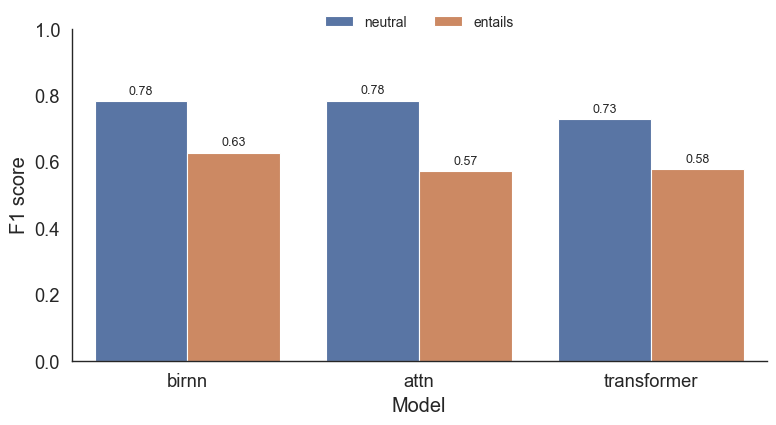

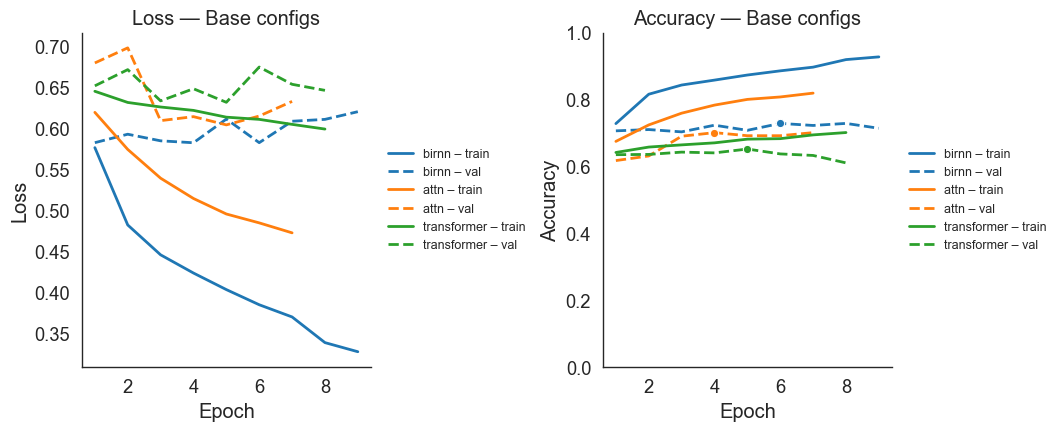

In [91]:
if TRAIN_BASE_MODELS:
    all_base_test_results = evaluate_all_models(trained_base_models, test_loader, device=MY_DEVICE, normalize_cm=True)
    plot_f1_by_model(all_base_test_results, class_names=("neutral","entails"), order=["birnn","attn","transformer"], save_path="figs/f1_by_base_models.png")

    _, _ = plot_learning_curves(histories, title_suffix="Base configs", smooth=0, save_path="figs/learning_curves_base_models.png")


In [92]:
import itertools, time, json, os
from datetime import datetime

def build_birnn_with(overrides: dict):
    """Fresh BiRNN with overrides; embeddings kept frozen."""
    base = default_model_configs(vocabulary.get_vocab_size())["birnn"]
    cfg = dict(base)
    cfg.update(overrides)
    m = BiRNNModel(**cfg).to(MY_DEVICE)
    set_embeddings_trainable(m, False)
    return m

def _combo_dicts(grid: dict):
    keys = list(grid.keys())
    for vals in itertools.product(*[grid[k] for k in keys]):
        yield dict(zip(keys, vals))

def sweep_birnn(grid: dict,
                tag: str = "birnn_ablation",
                train_cfg: "TrainConfig" = None,
                eval_on_test: bool = False):
    """
    Run all combinations in `grid` (e.g., {"embed_dim":[16,96], "hidden_dim":[16,96]}).
    - Does NOT reseed; uses whatever seed you set earlier.
    - By default, does NOT evaluate on test to avoid leakage.
    Returns: (df, out_csv_path)
    """
    if train_cfg is None:
        train_cfg = TrainConfig()

    os.makedirs("tuning_runs", exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    out_csv = f"tuning_runs/{tag}_{ts}.csv"

    combos = list(_combo_dicts(grid))
    print(f"[sweep_birnn] {len(combos)} combinations -> {out_csv}")

    for i, overrides in enumerate(combos, start=1):
        model = build_birnn_with(overrides)
        total_params, trainable_params = count_params(model)

        t0 = time.time()
        row = {
            "model": "birnn",
            **overrides,
            "total_params": total_params,
            "trainable_params": trainable_params,
        }

        try:
            trained = train_single_model(
                model, train_loader, val_loader, device=MY_DEVICE, config=train_cfg
            )
            row["train_time_s"] = round(time.time() - t0, 2)

            # Validation metrics (quiet)
            val_res = evaluate_model(trained, val_loader, device=MY_DEVICE)
            row.update({
                "val_acc": float(val_res["accuracy"]),
                "val_macro_f1": float(val_res["macro_avg"]["f1"]),
            })

            # Optional test eval (off by default)
            if eval_on_test:
                test_res = evaluate_model(trained, test_loader, device=MY_DEVICE)
                row.update({
                    "test_acc": float(test_res["accuracy"]),
                    "test_macro_f1": float(test_res["macro_avg"]["f1"]),
                })

            # Record the (key) training settings used
            row["train_cfg"] = json.dumps({
                "epochs": train_cfg.epochs,
                "lr": train_cfg.lr,
                "weight_decay": train_cfg.weight_decay,
                "max_grad_norm": train_cfg.max_grad_norm,
                "lr_plateau_factor": train_cfg.lr_plateau_factor,
                "lr_plateau_patience": train_cfg.lr_plateau_patience,
                "early_stop_patience": getattr(train_cfg, "early_stop_patience", None),
                "freeze_emb_epochs": getattr(train_cfg, "freeze_emb_epochs", 0),
            })

        except Exception as e:
            row.update({
                "train_time_s": round(time.time() - t0, 2),
                "val_acc": float("nan"),
                "val_macro_f1": float("nan"),
                "test_acc": float("nan"),
                "test_macro_f1": float("nan"),
                "error": str(e),
            })

        # Append this run to CSV (write header only once)
        pd.DataFrame([row]).to_csv(out_csv, mode="a", index=False, header=(i == 1))

        # Cleanup
        try: del trained
        except: pass
        del model
        if CUDA: torch.cuda.empty_cache()

        # Lightweight progress
        print(f"  [{i}/{len(combos)}] {overrides} -> val_f1={row.get('val_macro_f1', float('nan')):.3f}")

    df = pd.read_csv(out_csv)
    print(f"\nSaved {len(df)} runs to {out_csv}")

    return df, out_csv


In [93]:
grid = {
    "embed_dim":[16,64,96], 
    "hidden_dim":[16,64,96]
    }

df, csv_path = sweep_birnn(grid, tag="birnn_grid", eval_on_test=False)

[sweep_birnn] 9 combinations -> tuning_runs/birnn_grid_20251015-221952.csv
Epoch 01/10 | LR: 1.00e-03 | Train: loss 0.6433, acc 0.6493 | Val: loss 0.6640, acc 0.6242 | **
Epoch 02/10 | LR: 1.00e-03 | Train: loss 0.6110, acc 0.6901 | Val: loss 0.6383, acc 0.6518 | **
Epoch 03/10 | LR: 1.00e-03 | Train: loss 0.5946, acc 0.7082 | Val: loss 0.6205, acc 0.6756 | **
Epoch 04/10 | LR: 1.00e-03 | Train: loss 0.5797, acc 0.7245 | Val: loss 0.6251, acc 0.6741 | 
Epoch 05/10 | LR: 1.00e-03 | Train: loss 0.5667, acc 0.7370 | Val: loss 0.6168, acc 0.6764 | **
Epoch 06/10 | LR: 1.00e-03 | Train: loss 0.5529, acc 0.7530 | Val: loss 0.6220, acc 0.6702 | 
Epoch 07/10 | LR: 1.00e-03 | Train: loss 0.5437, acc 0.7608 | Val: loss 0.6257, acc 0.6687 | 
Epoch 08/10 | LR: 5.00e-04 | Train: loss 0.5337, acc 0.7699 | Val: loss 0.6291, acc 0.6687 | 
Early stopping (no val_acc improvement in 3 epochs).
  [1/9] {'embed_dim': 16, 'hidden_dim': 16} -> val_f1=0.676
Epoch 01/10 | LR: 1.00e-03 | Train: loss 0.6183, acc

In [94]:
# get best by validation macro-F1
best = df.sort_values("val_macro_f1", ascending=False).iloc[0]

# Retrain best config and evaaluate test 
best_model = build_birnn_with({"embed_dim": int(best.embed_dim),
                               "hidden_dim": int(best.hidden_dim)})
best_trained = train_single_model(best_model, train_loader, val_loader, MY_DEVICE, config=TrainConfig())


Epoch 01/10 | LR: 1.00e-03 | Train: loss 0.5760, acc 0.7267 | Val: loss 0.5977, acc 0.6794 | **
Epoch 02/10 | LR: 1.00e-03 | Train: loss 0.4824, acc 0.8143 | Val: loss 0.5979, acc 0.6825 | **
Epoch 03/10 | LR: 1.00e-03 | Train: loss 0.4452, acc 0.8418 | Val: loss 0.5910, acc 0.6887 | **
Epoch 04/10 | LR: 1.00e-03 | Train: loss 0.4206, acc 0.8610 | Val: loss 0.5881, acc 0.7048 | **
Epoch 05/10 | LR: 1.00e-03 | Train: loss 0.3999, acc 0.8761 | Val: loss 0.6055, acc 0.7117 | **
Epoch 06/10 | LR: 1.00e-03 | Train: loss 0.3830, acc 0.8885 | Val: loss 0.6071, acc 0.7209 | **
Epoch 07/10 | LR: 5.00e-04 | Train: loss 0.3691, acc 0.8973 | Val: loss 0.6068, acc 0.7101 | 
Epoch 08/10 | LR: 5.00e-04 | Train: loss 0.3385, acc 0.9205 | Val: loss 0.6177, acc 0.7239 | **
Epoch 09/10 | LR: 5.00e-04 | Train: loss 0.3257, acc 0.9279 | Val: loss 0.6441, acc 0.7178 | 
Epoch 10/10 | LR: 2.50e-04 | Train: loss 0.3147, acc 0.9352 | Val: loss 0.6673, acc 0.7009 | 


In [95]:
test_res = evaluate_model(best_trained, test_loader, device=MY_DEVICE)
print(f"\nFinal test macro-F1: {test_res['macro_avg']['f1']:.3f}")


Final test macro-F1: 0.694


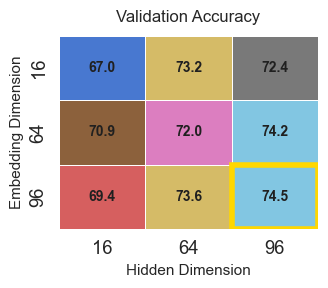

In [96]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_val_acc_heatmap(data, 
                         metric="val_acc",
                         title="Validation Accuracy",
                         cmap=None,
                         save_path=None):
    """
    ACL-style heatmap of validation accuracy for (embed_dim, hidden_dim).
    """
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy()

    needed = ["embed_dim", "hidden_dim", metric]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = df[needed].copy()
    df["embed_dim"] = pd.to_numeric(df["embed_dim"])
    df["hidden_dim"] = pd.to_numeric(df["hidden_dim"])
    df = df.sort_values(["embed_dim", "hidden_dim"])

    grid = df.pivot(index="embed_dim", columns="hidden_dim", values=metric)

    best_val = grid.values.max()
    best_idx = np.unravel_index(np.nanargmax(grid.values), grid.shape)
    best_row = grid.index[best_idx[0]]
    best_col = grid.columns[best_idx[1]]
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.5)  # readable in one column
    if cmap is None:
        cmap = sns.color_palette("muted", as_cmap=True)

    plt.figure(figsize=(3.2, 2.8))  # single-column ACL figure
    ax = sns.heatmap(
        grid * 100.0,
        annot=True,
        fmt=".1f",
        cmap=cmap,
        cbar=False,
        linewidths=0.6,
        linecolor="white",
        annot_kws={"fontsize": 10, "weight": "semibold", "color": "#202020"},
    )

    ax.set_xlabel("Hidden Dimension", fontsize=11)
    ax.set_ylabel("Embedding Dimension", fontsize=11)
    ax.set_title(f"{title}", fontsize=12, pad=10)

    # highlight best cell
    rect = Rectangle((best_idx[1], best_idx[0]), 1, 1,
                     fill=False, edgecolor="gold", linewidth=4.0)
    ax.add_patch(rect)

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout(pad=0.3)
    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Example
plot_val_acc_heatmap("tuning_runs/birnn_full_fixedseed.csv", save_path="figs/birnn_val_acc_heatmap.png")


# Ablation Study: Attention Mechanism

We investigate the impact of attention on our NLI model by varying **positions** and **types** of attention in the encoder-decoder framework. This will help us understand how much attention contributes to performance and which variants are most effective.

---

## Ablation: Attention Position

We experiment with three variants:

1. **Decoder-only (baseline)** $\rightarrow$ attention applied only in the decoder (current model).
2. **Encoder self-attention $\rightarrow$ decoder attention** – the encoder refines its outputs via self-attention before feeding into the decoder.
3. **No attention** – remove attention entirely and feed the decoder only the embedded input.


In [97]:

# 1. Decoder-only (baseline) -> use your existing model
model_dec_only = make_model("attn", vocab_size)

# 2. Encoder self-attention -> decoder attention
class NLIModelEncSelfAttn(NLIModelWithAttention):
    def forward(self, premise, hypothesis, premise_len, hypothesis_len):
        enc_out, _ = self.encoder(premise, premise_len)
        H = self.hidden_size
        enc_out = enc_out[:, :, :H] + enc_out[:, :, H:]  # reduce
        enc_mask = self.make_mask(premise, premise_len)

        # Apply encoder self-attention
        Q = enc_out
        K = enc_out
        V = enc_out
        scores = torch.bmm(Q, K.transpose(1,2)) / H**0.5
        scores = scores.masked_fill(~enc_mask.unsqueeze(1), -1e9)
        enc_out = torch.bmm(F.softmax(scores, dim=-1), V)

        init_hidden = enc_out.mean(dim=1).unsqueeze(0)
        dec_out = self.decoder(hypothesis, hypothesis_len, enc_out, enc_mask, init_hidden=init_hidden)
        p = enc_out.mean(dim=1)
        h = dec_out.mean(dim=1)
        feats = torch.cat([p,h,torch.abs(p-h),p*h], dim=1)
        logits = self.classifier(feats)
        return logits

model_enc_self = NLIModelEncSelfAttn(**default_model_configs(vocab_size)["attn"]).to(MY_DEVICE)

# 3. No attention -> decoder ignores encoder context
class NLIModelNoAttn(NLIModelWithAttention):
    def forward(self, premise, hypothesis, premise_len, hypothesis_len):
        enc_out, _ = self.encoder(premise, premise_len)
        H = self.hidden_size
        enc_out = enc_out[:, :, :H] + enc_out[:, :, H:]
        enc_mask = self.make_mask(premise, premise_len)
        init_hidden = enc_out.mean(dim=1).unsqueeze(0)
        # decoder uses zeroed context
        dec_out = self.decoder(hypothesis, hypothesis_len, torch.zeros_like(enc_out), enc_mask, init_hidden=init_hidden)
        p = enc_out.mean(dim=1)
        h = dec_out.mean(dim=1)
        feats = torch.cat([p,h,torch.abs(p-h),p*h], dim=1)
        logits = self.classifier(feats)
        return logits

model_no_attn = NLIModelNoAttn(**default_model_configs(vocab_size)["attn"]).to(MY_DEVICE)

## Ablation: Attention Type


In [98]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, dec_hidden, enc_out, mask=None):
        dec_hidden_exp = dec_hidden.unsqueeze(1)
        score = self.v(torch.tanh(self.W1(dec_hidden_exp) + self.W2(enc_out))).squeeze(-1)
        if mask is not None:
            score = score.masked_fill(~mask, -1e9)
        attn_weights = F.softmax(score, dim=-1)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_out).squeeze(1)
        return context, attn_weights

class NLIModelBahdanau(NLIModelWithAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.decoder.attention = BahdanauAttention(self.hidden_size)

model_bahdanau = NLIModelBahdanau(**default_model_configs(vocab_size)["attn"]).to(MY_DEVICE)

In [99]:
attention_models = {
    "Decoder-only": model_dec_only,
    "Encoder self-attn": model_enc_self,
    "No attention": model_no_attn,
    "Bahdanau": model_bahdanau
}

trained_attention_models = train_all_models(attention_models, train_loader, val_loader, MY_DEVICE)



>>> Training Decoder-only
Epoch 01/10 | LR: 1.00e-03 | Train: loss 0.6023, acc 0.6938 | Val: loss 0.6337, acc 0.6472 | **
Epoch 02/10 | LR: 1.00e-03 | Train: loss 0.5255, acc 0.7753 | Val: loss 0.6283, acc 0.6741 | **
Epoch 03/10 | LR: 1.00e-03 | Train: loss 0.4795, acc 0.8153 | Val: loss 0.6345, acc 0.6979 | **
Epoch 04/10 | LR: 1.00e-03 | Train: loss 0.4572, acc 0.8313 | Val: loss 0.6273, acc 0.6910 | 
Epoch 05/10 | LR: 1.00e-03 | Train: loss 0.4386, acc 0.8468 | Val: loss 0.6073, acc 0.7155 | **
Epoch 06/10 | LR: 1.00e-03 | Train: loss 0.4225, acc 0.8596 | Val: loss 0.6059, acc 0.7193 | **
Epoch 07/10 | LR: 1.00e-03 | Train: loss 0.4104, acc 0.8691 | Val: loss 0.6210, acc 0.7078 | 
Epoch 08/10 | LR: 1.00e-03 | Train: loss 0.3991, acc 0.8760 | Val: loss 0.6627, acc 0.6902 | 
Epoch 09/10 | LR: 5.00e-04 | Train: loss 0.3900, acc 0.8805 | Val: loss 0.6283, acc 0.7078 | 
Early stopping (no val_acc improvement in 3 epochs).

>>> Training Encoder self-attn
Epoch 01/10 | LR: 1.00e-03 | Tra

# Results from Ablation Studies

## Results of Hyper-param tuning ablation


## Results from Attention Ablation


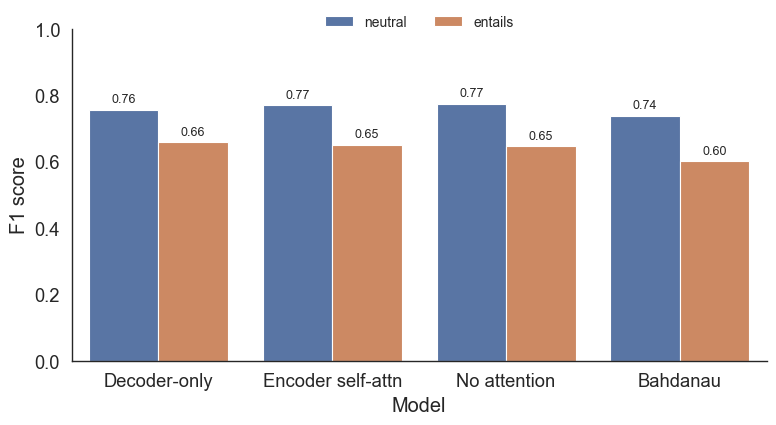

,model,class,f1,support
0,Decoder-only,neutral,0.756452,1284
1,Decoder-only,entails,0.659142,842
2,Encoder self-attn,neutral,0.770671,1284
3,Encoder self-attn,entails,0.651659,842
4,No attention,neutral,0.774913,1284
5,No attention,entails,0.646098,842
6,Bahdanau,neutral,0.738114,1284
7,Bahdanau,entails,0.601423,842


In [100]:
attention_ablation_results = evaluate_all_models(trained_attention_models, test_loader, device=MY_DEVICE, normalize_cm=True)
plot_f1_by_model(attention_ablation_results, save_path="figs/f1_by_attention_ablation.png", ) # order=["Decoder-only (Base)","Bahdanau","Encoder self-attn","No attention"]



# Qualitative Results

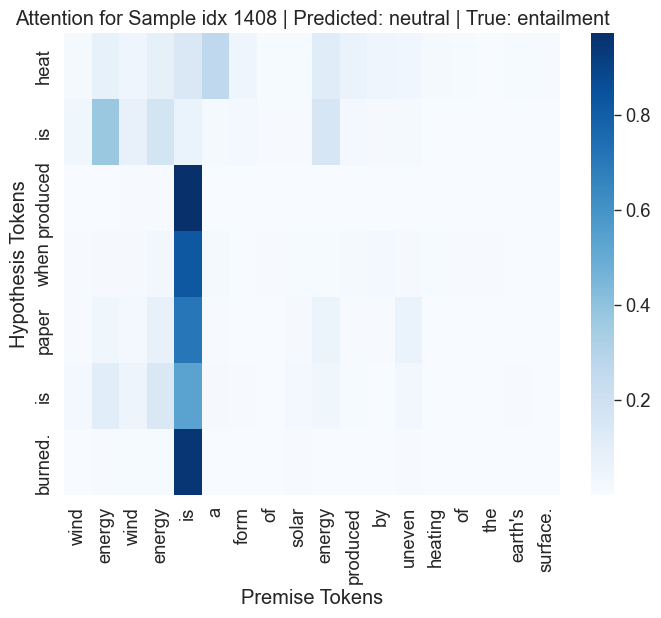

Sample index: 1408
Premise: wind energy wind energy is a form of solar energy produced by uneven heating of the earth's surface.
Hypothesis: heat is produced when paper is burned.
Predicted: neutral
True Label: entailment
Logits: tensor([[-1.0525,  0.8817]])


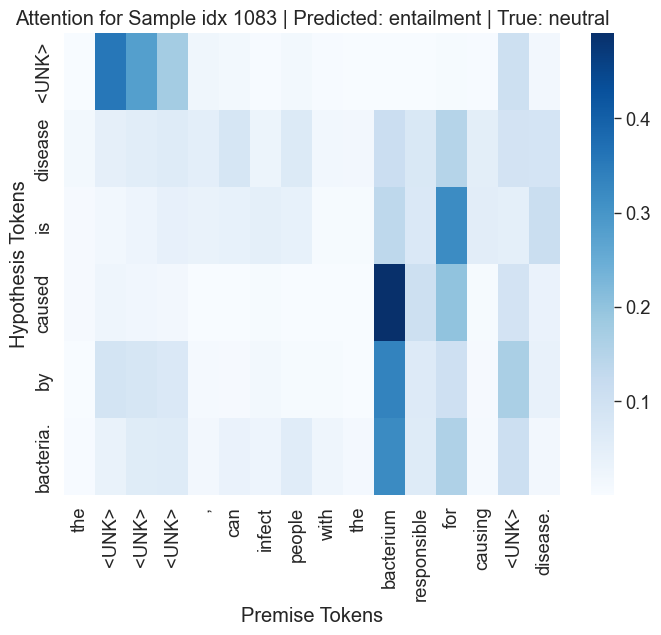

Sample index: 1083
Premise: the <UNK> <UNK> <UNK> , can infect people with the bacterium responsible for causing <UNK> disease.
Hypothesis: <UNK> disease is caused by bacteria.
Predicted: entailment
True Label: neutral
Logits: tensor([[ 0.9615, -0.3655]])


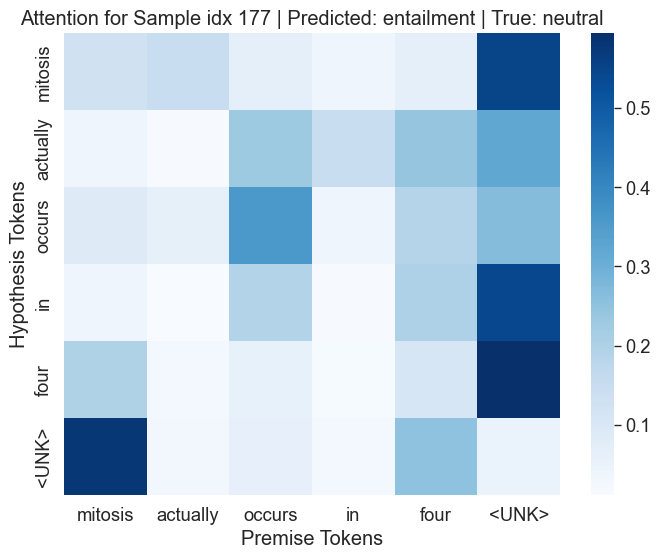

Sample index: 177
Premise: mitosis actually occurs in four <UNK>
Hypothesis: mitosis actually occurs in four <UNK>
Predicted: entailment
True Label: neutral
Logits: tensor([[ 2.0537, -1.1942]])


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random

# Pick a model (attention-based) and set to eval
model = base_models['attn']
model.eval()

num_samples = 3  # Adjust this to the number of samples you want to test (e.g., 3 random samples)
sample_indices = random.sample(range(len(test_dataset)), num_samples)  # Pick `num_samples` random indices

for idx in sample_indices:
    sample = test_dataset[idx]

    # Move tensors to device and add batch dim
    premise = sample['premise'].unsqueeze(0).to(MY_DEVICE)        # [1, T]
    hypothesis = sample['hypothesis'].unsqueeze(0).to(MY_DEVICE)  # [1, T]
    premise_len = torch.tensor([sample['premise_length']], device=MY_DEVICE)
    hypothesis_len = torch.tensor([sample['hypothesis_length']], device=MY_DEVICE)

    # --- Forward pass through encoder + decoder ---
    with torch.no_grad():
        # Encode premise
        enc_out, _ = model.encoder(premise, premise_len)
        H = model.hidden_size
        enc_out = enc_out[:, :, :H] + enc_out[:, :, H:]  # sum forward/backward
        enc_mask = model.make_mask(premise, premise_len)
        init_hidden = enc_out.mean(dim=1).unsqueeze(0)
        
        # Decode hypothesis step by step and collect attention weights
        dec_out = []
        attention_matrix = []

        embedded = model.decoder.embedding(hypothesis)
        hidden = init_hidden
        B, L_t, _ = embedded.size()

        for t in range(L_t):
            input_step = embedded[:, t, :]
            context, attn_weights = model.decoder.attention(hidden.squeeze(0), enc_out, enc_mask)
            rnn_input = torch.cat([input_step, context], dim=1).unsqueeze(1)
            output, hidden = model.decoder.gru(rnn_input, hidden)
            dec_out.append(output)
            attention_matrix.append(attn_weights.cpu().numpy())

    # Convert attention matrix to numpy (L_t, L_p)
    attention_matrix = np.stack(attention_matrix, axis=0).squeeze(1)

    # Decode tokens for plotting
    xticks = [vocabulary.decode([t.item()])[0] for t in sample['premise']]
    yticks = [vocabulary.decode([t.item()])[0] for t in sample['hypothesis']]

    # --- Make Prediction ---
    with torch.no_grad():
        logits = model(premise, hypothesis, premise_len, hypothesis_len)  # Get logits
        predicted_class = logits.argmax(dim=1).item()  # Get predicted class index
        class_names = ["entailment", "neutral"]
        predicted_label = class_names[predicted_class]  # Map to label

    # Get the true label from the dataset
    true_label = sample['label'].item()
    true_label_name = class_names[true_label]  # Map true label index to string

    # Plot attention matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_matrix, annot=False, cmap='Blues', xticklabels=xticks, yticklabels=yticks)
    plt.xlabel("Premise Tokens")
    plt.ylabel("Hypothesis Tokens")
    plt.title(f"Attention for Sample idx {idx} | Predicted: {predicted_label} | True: {true_label_name}")
    plt.show()

    # Print the prediction, true label, and tokens
    print(f"Sample index: {idx}")
    print(f"Premise: {' '.join(xticks)}")
    print(f"Hypothesis: {' '.join(yticks)}")
    print(f"Predicted: {predicted_label}")
    print(f"True Label: {true_label_name}")
    print(f"Logits: {logits}")


## Object Oriented Programming codes here

_You can use multiple code snippets. Just add more if needed_
